# Turning the park boundary calculation into reusable functions

- This notebook takes the method provided in [quantification notebook](../Safer_park_quantification.ipynb) and tries to turn it into a reusable function that works with the other functions in the `safer_parks` module.
- We will try to simplify and use the APIs available where possible.


In [11]:
import pandas as pd
import geopandas as gpd
import fiona
import osmnx as ox
from shapely.ops import unary_union
import shapely
import re
import folium
import safer_parks as sp
import importlib
# import osdatahub
# from osdatahub import OpenDataDownload

importlib.reload(sp)


<module 'safer_parks' from '/home/maeve/Reproducible_analysis_development/src/safer_parks/__init__.py'>

In [12]:
# check versions of different libraries

print(ox.__version__)

2.0.4


In [13]:
# location = "Peel Park, Bradford, UK"
location = "Lister Park, Bradford, UK"

First, I'm just checking that I can't do this super simply.

In [14]:
tags = {
    'leisure': ['park'],
    'landuse': ['forest', 'meadow'],
    'natural': ['wood', 'scrub']
}

parks = ox.features.features_from_address(location, tags, 200)
park = parks.iloc[0]
park_polygon_1 = park.geometry  # unbuffered!

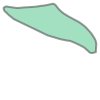

In [15]:
park_polygon_1

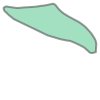

In [16]:
park_polygon_2 = sp.park_polygon(location)
park_polygon_2

In [17]:
type(park_polygon_2)

shapely.geometry.polygon.Polygon

In [18]:
shapely.equals(park_polygon_1, park_polygon_2)

np.True_

OK, these are identical. Instead, I'm going to us Fran's technique, and then see how I can break it down into small modules.

Instead of loading the data from a local file like this:

```python
# read in OS Open Greenspace data

print(fiona.listlayers('Data/opgrsp_gb.gpkg'))
os_greenspace_access =gpd.read_file('Data/opgrsp_gb.gpkg', layer ='access_point')
os_greenspace_site =gpd.read_file('Data/opgrsp_gb.gpkg', layer ='greenspace_site')
```

I want to try using some form of API/on the fly loading.

1. OS Open Greenspace data, both access_point and greenspace_site layers.
2. Create a subset in the Bradford LAD.

In [24]:
# Instead of single park, trying all parks

region_location = "Bradford, West Yorkshire, England"

tags = {
    'leisure': ['park'],
    'landuse': ['forest', 'meadow'],
    'natural': ['wood', 'scrub']
}

parks = ox.features.features_from_address(region_location, tags, 2000)

In [26]:
parks.explore()

# ok, so that works

In [27]:
parks.columns

Index(['geometry', 'natural', 'leisure', 'name', 'name:pronunciation',
       'wikidata', 'wikipedia', 'source', 'note', 'leaf_type', 'landuse',
       'type'],
      dtype='object')

In [30]:
parks_subset = parks[['name', 'geometry']].copy()

parks_subset['Type (OSM)'] = parks[['natural', 'leisure', 'landuse']].apply(lambda x: ', '.join(sorted(x.dropna().astype(str))),axis=1)